# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats

## 1.Завантаження залежних та незалежних вибірок з текстових файлів. 

         x        y
0  10.2616  11.0431
1  11.3428  16.3150
2   7.4301   9.6206
3  11.7226  12.7664
4   8.2145  11.0821


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

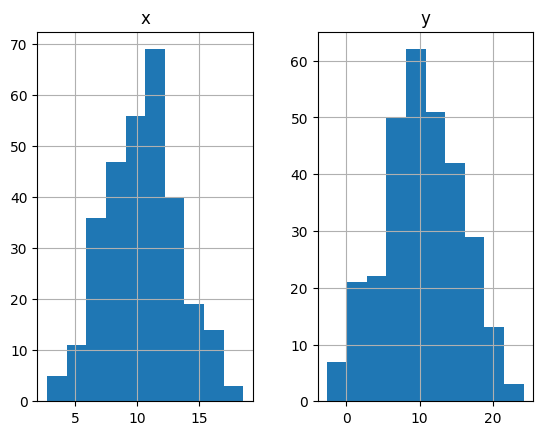

In [13]:
path = "../data_lab4/dep/normm=,s!=3.txt"
columns = ['x','y']
df = pd.read_csv(path, delimiter=" ", header=None, names=columns)
word_to_check = "indep"
if word_to_check in path:
    x_values = df[df['y'] == 0]['x'].reset_index(drop=True)
    y_values = df[df['y'] == 1]['x'].reset_index(drop=True)
    # Create a new DataFrame with 'x' and 'y' columns
    df = pd.DataFrame({'x': x_values, 'y': y_values})
    independent = True
else:
    independent = False    
print(df.head())
df.hist()

## Creating class for calculation quantiles

In [4]:
# Коефіцієнти для формули
C0 = 2.515_517
C1 = 0.802_853
C2 = 0.010_328
D1 = 1.432_788
D2 = 0.189_265_9
D3 = 0.001_308

class Quantile:
    
    @classmethod
    def calculate_quantile(cls, p):
        if p > 0.5:
            t = np.sqrt(-2 * np.log(1 - p))
            quantile = (t - ((C0 + C1 * t + C2 * t ** 2) / (1 + D1 * t + D2 * t ** 2 + D3 * t ** 3)))
        else:
            t = np.sqrt(-2 * np.log(p))
            quantile = -(t - ((C0 + C1 * t + C2 * t ** 2) / (1 + D1 * t + D2 * t ** 2 + D3 * t ** 3)))

        return quantile
        
    @staticmethod
    def student_quantile(p, v):
        up = Quantile.calculate_quantile(p)
        tpv = up + (1 / v) * (1 / 4) * (up ** 3 + up) + (1 / v ** 2) * (1 / 96) * (
            5 * up ** 5 + 16 * up ** 3 + 3 * up) + (1 / v ** 3) * (1 / 384) * (
                  3 * up ** 7 + 19 * up ** 5 + 17 * up ** 3 - 15 * up) + (1 / v ** 4) * (1 / 92_160) * (
                  79 * up ** 9 + 779 * up ** 7 + 1_482 * up ** 5 - 1_920 * up ** 3 - 945 * up)
        return tpv
    
    @staticmethod
    def fisher_quantile(p ,v1, v2):
        up = Quantile.calculate_quantile(p)   

        sigma = 1/v1 + 1/v2
        delta = 1/v1 - 1/v2
        
        z = (up * np.sqrt(sigma / 2) -
         (1 / 6) * delta * (up**2 + 2) +
         np.sqrt(sigma / 2) * (sigma / 24 * (up**2 + 3 * up) + (1 / 72) * (delta**2 / sigma) * (up**3 + 11 * up)) -
         (sigma * delta / 120) * (up**4 + 9 * up**2 + 8) +
         (delta**3 / (3240 * sigma)) * (3 * up**4 + 7 * up**2 - 16) +
         np.sqrt(sigma / 2) * (sigma**2 / 1920 * (up**5 + 20 * up**3 + 15 * up)) +
         (delta**4 / 2880) * (up**5 + 44 * up**3 + 183 * up) +
         (delta**5 / (155520 * sigma**2)) * (9 * up**5 + 284 * up**3 + 1513 * up)
        )

        return np.exp(2*z)

## Критерії перевірки однорідності двох залежних вибірок: критерії перевірки рівності дисперсій та середніх + критерій знакових рангів Вілкоксона

In [5]:
class DependentSamples:
    @classmethod
    def create_thrird_sample(cls, df):
        df['z'] = df['x']-df['y']

        z_mean = np.mean(df['z'])
        z_std = np.std(df['z'], ddof=1)
       
        return DependentSamples.calculate_t(len(df)-1, z_mean, z_std)
    
    @classmethod
    def calculate_t(cls, length, z_mean, z_std):
        if z_mean==0 and z_std==0:
            t=0
        else:
            t = z_mean*np.sqrt(length)/z_std
        return DependentSamples.is_mean_equal(t, length-1)

    @classmethod
    def is_mean_equal(cls, t, n):
        print('t equals: '+str(t))
        print('Quantile: '+str(Quantile.student_quantile(1-0.05/2, n)))
        return np.abs(t)<=Quantile.student_quantile(1-0.05/2, n)

    # @classmethod
    # def is_variances_equal(cls, t, n):
    #     print('t equals: '+str(t))
    #     print('Quantile: '+str(Quantile.student_quantile(1-0.05/2, n)))
    #     return np.abs(t)<=Quantile.student_quantile(1-0.05/2, n)
    
    @classmethod
    def calculate_statistic(cls, df):
        squared_x_std = np.std(df['x'], ddof=1)**2
        squared_y_std = np.std(df['y'], ddof=1)**2
        if(squared_x_std>=squared_y_std):
            f=squared_x_std/squared_y_std
            v1 = df['x'].count() - 1
            v2 = df['y'].count() - 1 
        else:
            f=squared_y_std/squared_x_std
            v1 = df['y'].count() - 1 
            v2 = df['x'].count() - 1
        
        #check is variances coincide
        f_fisher = Quantile.fisher_quantile(0.95,v1,v2)
        print('F:' +str(f))
        print('F fisher:' +str(f_fisher))
        return f<=f_fisher

    @classmethod
    def create_sample_signs_ranks(cls, df):
        df['z'] = df['x']-df['y']

        df['s'] = [1 if z > 0 else 0 if z < 0 else None for z in df['z']]
        df.dropna()
        df['|z|'] = [np.abs(x) for x in df['z']]
        df['r'] = df['|z|'].rank()
        df['s*r'] = df['r']*df['s']
        t = sum( df['s*r'])
        return t
        
    @classmethod
    def calculate_standardized_statistics_u(cls, n, t):
        et=1/4*n*(n+1)
        dt=1/24*n*(n+1)*(2*n+1)
        return (t-et)/(np.sqrt(dt))
        

    @classmethod
    def is_functions_shifted(cls, u):
        return np.abs(u)>Quantile.calculate_quantile(1-0.05/2)
        
    @staticmethod
    def check_for_homogeneity(df):
        mean_equal = DependentSamples.create_thrird_sample(df)
        varians_equal = DependentSamples.calculate_statistic(df)
        print('Is mean equals: '+str(mean_equal))
        print('Is varians equals: '+str(varians_equal))

    @staticmethod
    def check_for_homogeneity(df):
        mean_equal = DependentSamples.create_thrird_sample(df)
        varians_equal = DependentSamples.calculate_statistic(df)
        print('Is mean equals: '+str(mean_equal))
        print('Is varians equals: '+str(varians_equal))
        if mean_equal and varians_equal:
            print('homogeneous sample')
        else:
            print('NOT homogeneous sample')

    @staticmethod
    def calculate_rank_with_wilcoxon(df):
        res = DependentSamples.create_sample_signs_ranks(df)
            
        return res

#### Test

In [6]:
DependentSamples.check_for_homogeneity(df)
t = DependentSamples.calculate_rank_with_wilcoxon(df)
u = DependentSamples.calculate_standardized_statistics_u(df['x'].count(),t)
print('u equals: '+str(u))
print('quantile equals: '+str(Quantile.calculate_quantile(1-0.05/2)))
print('is sfit present: '+str(DependentSamples.is_functions_shifted(u)))


t equals: 0.13559869279583775
Quantile: 1.9683892292999465
F:3.1593529249382555
F fisher:1.2098984878687653
Is mean equals: True
Is varians equals: False
NOT homogeneous sample
u equals: 0.09709064036039616
quantile equals: 1.960392179315197
is sfit present: False


## Критерії перевірки однорідності двох незалежних вибірок: критерії перевірки рівності дисперсій та середніх + ранговий критерій, заданий індивідуальним варіантом.

In [7]:
class IndependentSamples:
    @classmethod
    def calculate_weighted_average_and_t(cls, df):
        x_mean = np.mean(df['x'])
        y_mean = np.mean(df['y'])
        x_dispersion = np.std(df['x'], ddof=1)**2
        y_dispersion = np.std(df['y'], ddof=1)**2
        x_n =df['x'].count()
        y_n =df['y'].count()

        weighted_average = ((x_n-1)*x_dispersion+(y_n-1)*y_dispersion)/(x_n+y_n-2)
        
        t = (x_mean-y_mean)/(np.sqrt(weighted_average/x_n+weighted_average/y_n))
        
        print('weighted average: '+str(weighted_average))
        print('t equals: '+str(t))
        
        return IndependentSamples.is_mean_equal(t, x_n+y_n-2)

    @classmethod
    def is_mean_equal(cls, t, v):
        print('Quantile: '+str(Quantile.student_quantile(1-0.05/2, v)))
        return np.abs(t)<=Quantile.student_quantile(1-0.05/2, v)

    @classmethod
    def calculate_criterion_with_welch_correction(cls, df):
        x_mean = np.mean(df['x'])
        y_mean = np.mean(df['y'])
        x_dispersion = np.std(df['x'], ddof=1)**2
        y_dispersion = np.std(df['y'], ddof=1)**2
        x_n =df['x'].count()
        y_n =df['y'].count()
        
        t = (x_mean-y_mean)/(np.sqrt(x_dispersion/x_n+y_dispersion/y_n))
        
        v = (x_dispersion/x_n+y_dispersion/y_n)**2*((1/(x_n-1)*(x_dispersion/x_n)**2)+(1/(y_n-1)*(y_dispersion/y_n)**2))**-1

        print('v: '+str(v))
        print('t equals: '+str(t))
        
        return IndependentSamples.is_mean_equal(t, v)

    @classmethod
    def claculate_rank_shift_criterion(cls, df, n1, n2):
        v = sum(list(df))
        ev = 1/2*n1*n2
        dv = 1/12*n1*n2*(n1+n2+1)
        u = (v-ev)/np.sqrt(dv)
        print('v equals: '+str(v))
        print('E{V} equals: '+str(ev))
        print('D{V} equals: '+str(dv))
        print('u equals: '+str(u))
        quantile = Quantile.calculate_quantile(1-0.05/2)
        print('Quantile: '+str(quantile))
        return np.abs(u)<=quantile
    
    @staticmethod
    def check_for_homogeneity(df, varians_equal):

        if varians_equal:
            mean_equal = IndependentSamples.calculate_weighted_average_and_t(df)
        else:
            mean_equal = IndependentSamples.calculate_criterion_with_welch_correction(df)

        print('Is mean equals: '+str(mean_equal))
        print('Is varians equals: '+str(varians_equal))
        if mean_equal and varians_equal:
            print('homogeneous sample')
        else:
            print('NOT homogeneous sample')
       

    @staticmethod
    def calculate_rank_with_mann_whitney(df):
        result = {}
        for x_val in df['x']:
            inversions = 0
            for y_val in df['y']:
                if y_val < x_val:
                    inversions += 1
                elif y_val == x_val:
                    inversions += 0.5  # semi inversion
            result[x_val] = inversions
        shift_exist = IndependentSamples.claculate_rank_shift_criterion(result.values(), df['x'].count(), df['y'].count())
        if shift_exist:
            print('NO shift exist')
        else:
            print('shift exist')
            
        return shift_exist

#### Test

In [8]:
print(''+str(IndependentSamples.check_for_homogeneity(df, DependentSamples.calculate_statistic(df))))
res = IndependentSamples.calculate_rank_with_mann_whitney(df)

F:3.1593529249382555
F fisher:1.2098984878687653
v: 471.04308820296797
t equals: 0.13436371584161444
Quantile: 1.9654439911628643
Is mean equals: True
Is varians equals: False
NOT homogeneous sample
None
v equals: 45440
E{V} equals: 45000.0
D{V} equals: 4507500.0
u equals: 0.20724535658452234
Quantile: 1.960392179315197
NO shift exist


### Check wheather distribution normal or not

In [9]:
alpha = 0.05

# Shapiro-Wilk test for 'x'
statistic_x, p_value_x = stats.shapiro(df['x'])
normal_x = p_value_x > alpha
print(p_value_x)

# Shapiro-Wilk test for 'y'
statistic_y, p_value_y = stats.shapiro(df['y'])
normal_y = p_value_y > alpha
print(p_value_y)
# Checking normality for both 'x' and 'y'
if normal_x and normal_y:
    normal = True
else:
    normal = False

print(normal)

0.9368849992752075
0.47145769000053406
True


## Підрахунок і виведення у таблицю незсунених кількісних характеристики кожної виибірки, а також вибірки різниць у випадку залежних вибірок. 

### creating class for calculating a Quantitative Characteristics

In [10]:
class QuantitativeCharacteristics:

    def __init__(self,sample):
        self.sample = sample
        self.characteristic_fields_map = ["Mean", "Median", "Std", "Skewness", "Kurtosis", "Min", "Max"]
        self.characteristic_table_dictionary = dict()
        self.mean = None
        self.std_deviation = None
        self.a = None
        self.e = None
        self.sa = None
        self.se = None
    
    def add_to_dictionary(self, column_name, column_data):
        self.characteristic_table_dictionary.update({column_name: column_data})

    def display(self):
        self.add_characteristics()
        return self.characteristic_table_dictionary

    def add_characteristics(self):
        estimation = self.calculate_estimation()
        self.add_to_dictionary("Characteristic", self.characteristic_fields_map)
        self.add_to_dictionary("Estimation", estimation.keys())
        self.add_to_dictionary("SEM", estimation.values())
        confidence_intervals = self.calculate_confidence_interval(estimation)
        self.add_to_dictionary("95% Confidence Interval", confidence_intervals)

    def calculate_confidence_interval(self, estimation: dict):
        confidence_interval = list(range(0, 7))
        median_conf_interval = self.calculate_median_confidence_interval(list(estimation.keys())[1])
        confidence_interval[1] = f"[{median_conf_interval[0]}; {median_conf_interval[1]}]"
        confidence_interval[5] = "───"
        confidence_interval[6] = "───"

        v = len(self.sample) - 1
        student_quantile = Quantile.student_quantile(0.95, v)
        print("student_quantile: " + str(student_quantile))
        i = 0
        for key in estimation.keys():
            if (estimation.get(key) == "───"):
                i = i + 1
                continue
            upper_bound = round(key - student_quantile * estimation.get(key), 4)
            lower_bound = round(key + student_quantile * estimation.get(key), 4)
            confidence_interval[i] = f"[{upper_bound}; {lower_bound}]"

            i = i + 1

        return confidence_interval

    def calculate_median_confidence_interval(self, median):
        num_samples = 1000

        bootstrap_samples = [np.random.choice(self.sample, size=len(self.sample), replace=True) for _ in
                             range(num_samples)]

        bootstrap_medians = np.median(bootstrap_samples, axis=1)

        std_error_median = np.std(bootstrap_medians, ddof=1)
        v = len(self.sample) - 1
        student_quantile = Quantile.student_quantile(1 - 0.05 / 2, v)
        lower_bound = round(median - student_quantile * std_error_median, 4)
        upper_bound = round(median + student_quantile * std_error_median, 4)

        return lower_bound, upper_bound

    def calculate_normal_interval(self):
        v = len(self.sample) - 1
        student_quantile = Quantile.student_quantile(1 - 0.05 / 2, v)
        lower_bound = round(self.mean - student_quantile * self.std_deviation, 4)
        upper_bound = round(self.mean + student_quantile * self.std_deviation, 4)
        return lower_bound, upper_bound

    def calculate_estimation(self):
        estimation_map = dict()
        self.mean = round(np.mean(self.sample), 4)
        median = round(np.median(self.sample), 4)
        self.std_deviation = round(np.std(self.sample, ddof=1), 4)
        self.a = round(stats.skew(self.sample), 4)
        self.e = round(stats.kurtosis(self.sample), 4)
        minimum = round(min(self.sample), 4)
        maximum = round(max(self.sample), 4)

        n_len = len(self.sample)
        mean_std = round(self.std_deviation / np.sqrt(n_len), 4)
        std_std_deviation = round(self.std_deviation / np.sqrt(2 * n_len), 4)
        self.sa = round(np.sqrt(6 * n_len * (n_len - 1) / ((n_len - 2) * (n_len + 1) * (n_len + 3))), 4)
        self.se = round(
            np.sqrt(24 * n_len * (n_len - 1) ** 2 / ((n_len - 3) * (n_len - 2) * (n_len + 3) * (n_len + 5))), 4)

        estimation_map[self.mean] = mean_std
        estimation_map[median] = "───"
        estimation_map[self.std_deviation] = std_std_deviation
        estimation_map[self.a] = self.sa
        estimation_map[self.e] = self.se
        estimation_map[minimum] = "───"
        estimation_map[maximum] = "───"
        return estimation_map

#### Test

In [11]:
q_c1 = QuantitativeCharacteristics(df['x'])
q_c2 = QuantitativeCharacteristics(df['y'])
res1= pd.DataFrame(q_c1.display())
print(res1)
print('----------')
res2=  pd.DataFrame(q_c2.display())
print(res2)


student_quantile: 1.650323668219721
  Characteristic  Estimation     SEM 95% Confidence Interval
0           Mean     10.4041  0.1694      [10.1245; 10.6837]
1         Median     10.4610     ───         [9.995; 10.927]
2            Std      2.9336  0.1198        [2.7359; 3.1313]
3       Skewness      0.0426  0.1407       [-0.1896; 0.2748]
4       Kurtosis     -0.1957  0.2805       [-0.6586; 0.2672]
5            Min      2.7532     ───                     ───
6            Max     18.5376     ───                     ───
----------
student_quantile: 1.650323668219721
  Characteristic  Estimation     SEM 95% Confidence Interval
0           Mean     10.3576   0.301       [9.8609; 10.8543]
1         Median     10.0390     ───         [9.154; 10.924]
2            Std      5.2143  0.2129        [4.8629; 5.5657]
3       Skewness     -0.0185  0.1407       [-0.2507; 0.2137]
4       Kurtosis     -0.4099  0.2805        [-0.8728; 0.053]
5            Min     -2.5495     ───                     ───
6 

#### Calculate P value with CDF(using student quantile)

### Calculate paired t-test

In [12]:
if(independent):
    if(normal):
        print(1)
        print(str(IndependentSamples.check_for_homogeneity(df, DependentSamples.calculate_statistic(df))))
    else:
        print(2)
        res = IndependentSamples.calculate_rank_with_mann_whitney(df)
        print(res)
        q_c1 = QuantitativeCharacteristics(df['x'])
        q_c2 = QuantitativeCharacteristics(df['y'])
        res1= pd.DataFrame(q_c1.display())
        print(res1)
        print('----------')
        res2=  pd.DataFrame(q_c2.display())
        print(res2)     
        
else:      
    if(normal):
        print(3)
        DependentSamples.check_for_homogeneity(df)
    else:
        print(4) 
        t = DependentSamples.calculate_rank_with_wilcoxon(df)
        u = DependentSamples.calculate_standardized_statistics_u(df['x'].count(),t)
        print('u equals: '+str(u))
        print('quantile equals: '+str(Quantile.calculate_quantile(1-0.05/2)))
        print('is sfit present: '+str(DependentSamples.is_functions_shifted(u)))   

3
t equals: 0.13559869279583775
Quantile: 1.9683892292999465
F:3.1593529249382555
F fisher:1.2098984878687653
Is mean equals: True
Is varians equals: False
NOT homogeneous sample
